# Air Taxi Logistics - Capstone

Please fill out:

- Student name: Dicchyant Gurung
- Student pace: Self Paced
- Scheduled project review date/time: 8/30
- Instructor name: Jeff Herman

### Model:

- Explore Fastrak data to figure out traffic movement and density in the Bay Area
- Find traffic hotspots to serve as airtaxi hubs
- Analyze transporation needs to service each location
- Predict demand for air taxis
- Recommend service routes and hours of operations depending on demand

Data: https://pems.dot.ca.gov/?dnode=Clearinghouse&type=fastrak_hour&district_id=all&submit=Submit

In [1]:
import requests
import pandas as pd
import numpy as np
import googlemaps
import gmaps

from datetime import datetime
from itertools import combinations

from sklearn.metrics import calinski_harabasz_score

import matplotlib.pyplot as plt
%matplotlib inline

### Import Fastrak locations

In [2]:
# Create a list of column id's to rename the raw data

columns = ['Location Identifier', 'Timestamp', 'rc_location_id', 'rc_segment_id', 
           'State PM', 'Absolute Postmile', 'Latitude', 'Longitude', 'Angle', 'Name',
          'Abbrev', 'Freeway ID', 'Freeway Direction', 'District ID', 'County ID', 'City ID']

In [3]:
# Import FasTrak location dataset

df = pd.read_csv(r'all_text_fastrak_locations_2021_08_01.txt.gz', names=columns)

In [4]:
df.head()

,Location Identifier,Timestamp,rc_location_id,rc_segment_id,State PM,Absolute Postmile,Latitude,Longitude,Angle,Name,Abbrev,Freeway ID,Freeway Direction,District ID,County ID,City ID
0,24001,08/26/2011 23:28:03,156235,658795,5.94,69.8,37.93196,-122.400510,353.561459,I-580 @ Western,NaN,580,W,4,13,60620.0
1,12001,08/26/2011 23:28:03,156236,683982,13.07,70.5,38.21539,-122.137760,NaN,I-680S at I-80,NaN,680,S,4,95,23182.0
2,24901,08/26/2011 23:28:03,156237,708930,1.79,7.1,37.82446,-122.317436,11.877558,I-80W @ Metering Bridge,NaN,80,W,4,1,53000.0
3,12701,08/26/2011 23:28:03,156238,675869,1.05,5.4,37.86710,-122.200780,0.394050,SR-24W South of Gateway Blvd,NaN,24,W,4,13,54232.0
4,3501,08/26/2011 23:28:03,156239,708942,2.69,8.0,37.82643,-122.301260,13.242357,I-80W at I-580 Merge I-80 HOV coverage,NaN,80,W,4,1,53000.0


In [5]:
len(df)

153

There are a total of 153 FasTrak locations.

### Import Fastrak daily volumes

In [6]:
# Import daily volumes

df_daily = pd.read_csv('all_text_fastrak_day_2013_08.txt.gz', 
                       names=['Timestamp', 'Location Identifier', 'Total Flow Daily'])

In [7]:
df_daily.head()

,Timestamp,Location Identifier,Total Flow Daily
0,08/01/2013 00:00:00,200,14959
1,08/01/2013 00:00:00,201,4171
2,08/01/2013 00:00:00,300,8089
3,08/01/2013 00:00:00,301,770
4,08/01/2013 00:00:00,500,14682


### Import Fastrak hourly volumes

In [8]:
# Import hourly volumes

df_hourly = pd.read_csv(r'all_text_fastrak_hour_2013_08.txt.gz', 
                        names=['Timestamp', 'Location Identifier', 'Total Flow Hourly'])

In [9]:
df_hourly

,Timestamp,Location Identifier,Total Flow Hourly
0,08/01/2013 00:00:00,200,230
1,08/01/2013 00:00:00,201,31
2,08/01/2013 00:00:00,300,139
3,08/01/2013 00:00:00,301,1
4,08/01/2013 00:00:00,500,134
...,...,...,...
113827,08/31/2013 23:00:00,24201,0
113828,08/31/2013 23:00:00,24700,0
113829,08/31/2013 23:00:00,24701,0
113830,08/31/2013 23:00:00,24800,0


### Google Maps API

In [10]:
# Read api key from saved file

api_file = open('api-key.txt', 'r')
api_key = api_file.read()
api_file.close()

In [11]:
# Instantiate gmaps

gmaps.configure(api_key=api_key)

In [12]:
# Instantiate Python client library for gmaps

Gmaps = googlemaps.Client(key=api_key)

Python client library for Google maps enables us to work with Google Maps in our server. 
We need this specifically to use the Distance Matrix API that will allow us to calculate distances, time taken etc, between co-ordinates mapped in the google maps.

## Part I - EDA Daily

In [13]:
# Create a new dataframe with required columns

fastrak_location = df[['Location Identifier', 'Latitude', 'Longitude', 'Freeway Direction']].copy()

In [14]:
fastrak_location.head()

,Location Identifier,Latitude,Longitude,Freeway Direction
0,24001,37.93196,-122.400510,W
1,12001,38.21539,-122.137760,S
2,24901,37.82446,-122.317436,W
3,12701,37.86710,-122.200780,W
4,3501,37.82643,-122.301260,W


In [15]:
# Create a new column with co-ordinates as a tuple

fastrak_location['Coordinates'] = list(zip(fastrak_location.Latitude, fastrak_location.Longitude))

In [16]:
fastrak_location.head()

,Location Identifier,Latitude,Longitude,Freeway Direction,Coordinates
0,24001,37.93196,-122.400510,W,"(37.93196, -122.40051000000001)"
1,12001,38.21539,-122.137760,S,"(38.21539, -122.13776000000001)"
2,24901,37.82446,-122.317436,W,"(37.824459999999995, -122.31743600000001)"
3,12701,37.86710,-122.200780,W,"(37.8671, -122.20078000000001)"
4,3501,37.82643,-122.301260,W,"(37.82643, -122.30126000000001)"


In [17]:
# Build a base map

fig = gmaps.figure(center=(37.9, -122.2), zoom_level=8)
fig

Figure(layout=FigureLayout(height='420px'))

In [18]:
# Add fastrak locations as a symbol layer

fig.add_layer(gmaps.symbol_layer(fastrak_location.Coordinates, hover_text='Fastrak', fill_color='blue', stroke_color='blue', scale=2))
fig

Figure(layout=FigureLayout(height='420px'))

### Merge Fastrak location with daily flow of traffic

In [19]:
df_merge_daily = fastrak_location.merge(df_daily, on='Location Identifier')

In [20]:
df_merge_daily.head()

,Location Identifier,Latitude,Longitude,Freeway Direction,Coordinates,Timestamp,Total Flow Daily
0,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/01/2013 00:00:00,7592
1,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/02/2013 00:00:00,7978
2,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/03/2013 00:00:00,6655
3,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/04/2013 00:00:00,5742
4,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/05/2013 00:00:00,8642


In [21]:
# Split the Timestamp to show day for each entry

df_merge_daily['Day'] = [x[3:5] for x in df_merge_daily['Timestamp']]

In [22]:
df_merge_daily.head()

,Location Identifier,Latitude,Longitude,Freeway Direction,Coordinates,Timestamp,Total Flow Daily,Day
0,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/01/2013 00:00:00,7592,01
1,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/02/2013 00:00:00,7978,02
2,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/03/2013 00:00:00,6655,03
3,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/04/2013 00:00:00,5742,04
4,24001,37.93196,-122.40051,W,"(37.93196, -122.40051000000001)",08/05/2013 00:00:00,8642,05


### Total Daily Flow

In [23]:
# Calculate the total daily flow of traffic across all locations

df_merge_daily.groupby(by='Day').sum()

,Location Identifier,Latitude,Longitude,Total Flow Daily
Day,,,,
01,1951580,5783.896496,-18704.167863,563777
02,1951580,5783.896496,-18704.167863,551160
03,1951580,5783.896496,-18704.167863,426437
04,1951580,5783.896496,-18704.167863,382571
05,1951580,5783.896496,-18704.167863,510144
06,1951580,5783.896496,-18704.167863,541805
07,1951580,5783.896496,-18704.167863,550523
08,1951580,5783.896496,-18704.167863,553746
09,1951580,5783.896496,-18704.167863,539712


### Visuazlize the data

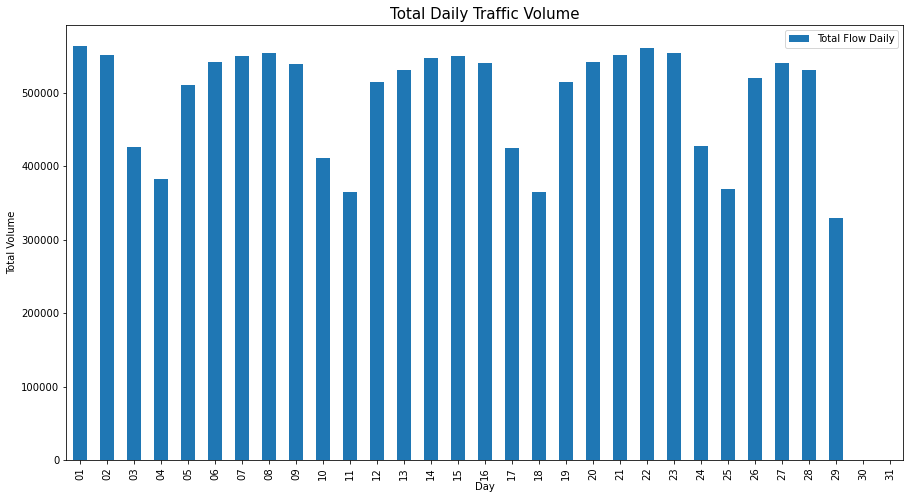

In [24]:
fig = df_merge_daily.groupby(by='Day').sum().plot(kind='bar', y='Total Flow Daily', figsize=(15,8))
fig.set_title('Total Daily Traffic Volume', fontsize=15)
fig.set_ylabel('Total Volume')
fig.set_xlabel('Day', labelpad=2)
plt.savefig(r'Total Daily Traffic Volume.png', bbox_inches='tight')
fig;

Looking at the total daily traffic flow in all fastrak locations, you can see a clear trend of traffic being higher during the weekdays than in the weekends. The two-day drop you see in the chart is during Saturday and Sunday with the traffic picking up significantly on Monday.

Within the 5 day week, you can also see a trend of traffic increasing as we move along the week. Thursday shows the highest flow of traffic in all the 4 weeks of the month.

### Direction of movement

In [25]:
# Group the Freeway Direction to calculate flow of traffic across each direaction

df_merge_daily.groupby(by='Freeway Direction').sum()

,Location Identifier,Latitude,Longitude,Total Flow Daily
Freeway Direction,,,,
E,12570531,42284.123163,-136364.334469,3857729
N,16882724,44458.353082,-144076.573059,2810716
S,19382347,50293.839458,-163012.842800,3263552
W,11663378,42264.475673,-136375.453425,4378074


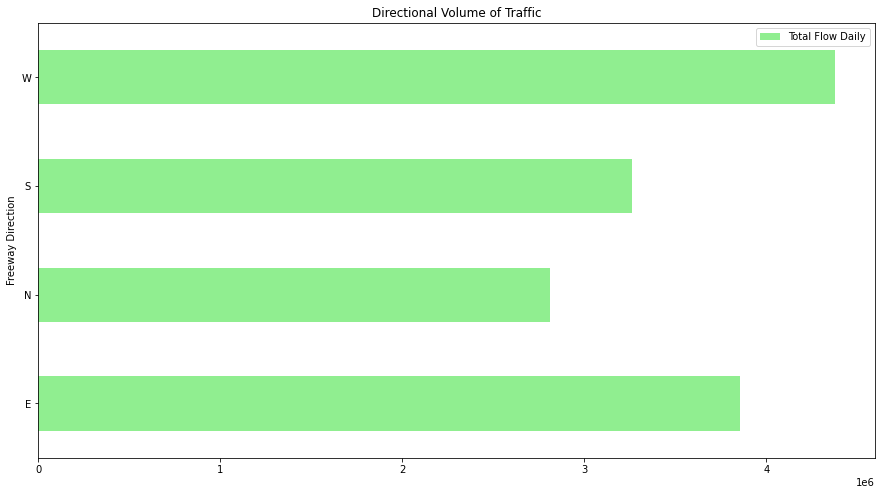

In [26]:
# Visualize the data

df_merge_daily.groupby(by='Freeway Direction').sum().plot(kind='barh', 
                    y='Total Flow Daily', figsize=(15,8), color='lightgreen',
                    title='Directional Volume of Traffic');
plt.savefig(r'Directional.png', bbox_inches='tight')

We can see that there is higher movement of traffic in either West or East directions. San Francisco being the central location of our analysis, we can note that most of these volumes seen could be from traffic moving in and out of the city. However, we will have to look into a bit deeper to figure out the exact location and direction where the traffic density is the highest. 

## Part II - Visualize volume in plot

### Density Blobs

The FasTrak location plot itself does not give us much information of the volumes seen at each location. Using the density parameter within gmaps.symbol layer we can change the size of each blob to represent the volume observed and identify locations with the highest traffic.

In [27]:
# Create a new dataframe with total volumes seen at each location

df_location = df_merge_daily.groupby(by='Location Identifier',as_index=False).sum().copy()

In [28]:
df_location.head()

,Location Identifier,Latitude,Longitude,Total Flow Daily
0,200,1174.47003,-3791.5728,383810
1,201,1174.47003,-3791.5728,104180
2,300,1172.57593,-3791.5387,187737
3,301,1172.57593,-3791.5387,17147
4,500,1171.75257,-3790.5219,363149


In [29]:
# We will drop the coordinates as they are the sum of all coordinates

df_location.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

In [30]:
df_location.head()

,Location Identifier,Total Flow Daily
0,200,383810
1,201,104180
2,300,187737
3,301,17147
4,500,363149


In [31]:
# Merge the above dataframe to create a new dataframe with total volumes and coordinates of each FasTrak location

df_coordinates = pd.merge(df_location, df_merge_daily, on ='Location Identifier', how ='inner')

In [32]:
df_coordinates.head()

,Location Identifier,Total Flow Daily_x,Latitude,Longitude,Freeway Direction,Coordinates,Timestamp,Total Flow Daily_y,Day
0,200,383810,37.88613,-122.3088,E,"(37.88613, -122.3088)",08/01/2013 00:00:00,14959,01
1,200,383810,37.88613,-122.3088,E,"(37.88613, -122.3088)",08/02/2013 00:00:00,15332,02
2,200,383810,37.88613,-122.3088,E,"(37.88613, -122.3088)",08/03/2013 00:00:00,12744,03
3,200,383810,37.88613,-122.3088,E,"(37.88613, -122.3088)",08/04/2013 00:00:00,10636,04
4,200,383810,37.88613,-122.3088,E,"(37.88613, -122.3088)",08/05/2013 00:00:00,14153,05


In [33]:
# Drop columns that are not required

df_coordinates.drop(['Timestamp', 'Total Flow Daily_y', 'Day'], axis=1, inplace=True)

In [34]:
# Rename columns for ease of use

df_coordinates.rename({'Total Flow Daily_x': 'Total Flow Daily'}, axis=1, inplace=True)

In [35]:
# We only need one instance at each location. Drop all duplicates.

df_coordinates.drop_duplicates(subset='Location Identifier', inplace=True)

In [36]:
df_coordinates.head()

,Location Identifier,Total Flow Daily,Latitude,Longitude,Freeway Direction,Coordinates
0,200,383810,37.88613,-122.3088,E,"(37.88613, -122.3088)"
31,201,104180,37.88613,-122.3088,W,"(37.88613, -122.3088)"
62,300,187737,37.82503,-122.3077,E,"(37.82503, -122.3077)"
93,301,17147,37.82503,-122.3077,W,"(37.82503, -122.3077)"
124,500,363149,37.79847,-122.2749,N,"(37.79847, -122.2749)"


In [37]:
len(df_coordinates)

153

### Normalize the total volume at each location

To be able to represent the volume in the plot, we will have to normalize or bring them down to a standard scale.

In [38]:
# Check the statistics

df_coordinates.describe()

,Location Identifier,Total Flow Daily,Latitude,Longitude
count,153.000000,153.000000,153.000000,153.000000
mean,12755.424837,93529.875817,37.803245,-122.249463
std,7123.093598,110467.338020,0.260635,0.231809
min,200.000000,0.000000,37.334600,-122.737100
25%,6000.000000,0.000000,37.631800,-122.422070
50%,13601.000000,53927.000000,37.798930,-122.290380
75%,18201.000000,139901.000000,37.945020,-122.109300
max,24901.000000,447536.000000,38.514250,-121.575439


In [39]:
# Divide each unit by max value and times that by 20 to create a normalized scale between 0 - 20

df_coordinates['Normalized Total Flow Daily'] = [round(x/447536) for x in df_coordinates['Total Flow Daily'] * 20]

In [40]:
df_coordinates

,Location Identifier,Total Flow Daily,Latitude,Longitude,Freeway Direction,Coordinates,Normalized Total Flow Daily
0,200,383810,37.886130,-122.308800,E,"(37.88613, -122.3088)",17
31,201,104180,37.886130,-122.308800,W,"(37.88613, -122.3088)",5
62,300,187737,37.825030,-122.307700,E,"(37.82503, -122.3077)",8
93,301,17147,37.825030,-122.307700,W,"(37.82503, -122.3077)",1
124,500,363149,37.798470,-122.274900,N,"(37.79847, -122.2749)",16
...,...,...,...,...,...,...,...
4588,24201,44496,38.024640,-122.109570,S,"(38.024640000000005, -122.10956999999999)",2
4619,24700,71385,37.769647,-122.413846,N,"(37.769647, -122.41384599999999)",3
4650,24701,7905,37.769647,-122.413846,S,"(37.769647, -122.41384599999999)",0
4681,24800,0,37.825710,-122.306710,N,"(37.82571, -122.30671000000001)",0


In [41]:
# Check the statistics of the newly created column

df_coordinates['Normalized Total Flow Daily'].describe()

count    153.000000
mean       4.163399
std        4.925040
min        0.000000
25%        0.000000
50%        2.000000
75%        6.000000
max       20.000000
Name: Normalized Total Flow Daily, dtype: float64

There seems be zero traffic flow for about 25% of the data. We will drop this as it will not help our analysis.

In [42]:
# Save the result in a new dataframe

df_density = df_coordinates[df_coordinates['Normalized Total Flow Daily'] != 0]

In [43]:
df_density

,Location Identifier,Total Flow Daily,Latitude,Longitude,Freeway Direction,Coordinates,Normalized Total Flow Daily
0,200,383810,37.886130,-122.308800,E,"(37.88613, -122.3088)",17
31,201,104180,37.886130,-122.308800,W,"(37.88613, -122.3088)",5
62,300,187737,37.825030,-122.307700,E,"(37.82503, -122.3077)",8
93,301,17147,37.825030,-122.307700,W,"(37.82503, -122.3077)",1
124,500,363149,37.798470,-122.274900,N,"(37.79847, -122.2749)",16
...,...,...,...,...,...,...,...
4526,24001,221540,37.931960,-122.400510,W,"(37.93196, -122.40051000000001)",10
4557,24200,220676,38.024640,-122.109570,N,"(38.024640000000005, -122.10956999999999)",10
4588,24201,44496,38.024640,-122.109570,S,"(38.024640000000005, -122.10956999999999)",2
4619,24700,71385,37.769647,-122.413846,N,"(37.769647, -122.41384599999999)",3


### Plot the volumes in each location

In [44]:
# Create a base map

fig2 = gmaps.figure(center=(37.9, -122.2), zoom_level=8)
fig2

Figure(layout=FigureLayout(height='420px'))

In [45]:
# Create a list to plot the normalized volume in each blob

scale = list(df_density['Normalized Total Flow Daily'])

In [46]:
# Create a list of names to add title to each blob. Each name will consist of the Location Identifier and 
# direction of movement at each location

fastrak_names = list(df_density['Location Identifier'].apply(lambda x: str(x)) + '-' +
                     df_density['Freeway Direction'].apply(lambda x: str(x)))

In [47]:
fastrak_names[:5]

['200-E', '201-W', '300-E', '301-W', '500-N']

In [48]:
# Visalize the data
fig2.add_layer(gmaps.symbol_layer(df_density.Coordinates, hover_text=fastrak_names, 
                                  fill_color='blue', fill_opacity=0.7,
                                  stroke_color='green', stroke_opacity=0.3,
                                  scale=scale))
fig2

Figure(layout=FigureLayout(height='420px'))

Blob scale is between (1 - 20) representing daily traffic flow between (20,000 - 400,000) approx.

Let's look into the hourly trends at each location.

## Part III  - EDA Hourly

### Hourly Traffic Flow

In [49]:
df_hourly.head()

,Timestamp,Location Identifier,Total Flow Hourly
0,08/01/2013 00:00:00,200,230
1,08/01/2013 00:00:00,201,31
2,08/01/2013 00:00:00,300,139
3,08/01/2013 00:00:00,301,1
4,08/01/2013 00:00:00,500,134


In [50]:
# Strip the hour out of the Timestamp

df_hourly['Hour'] = [x[-8:-6] for x in df_hourly['Timestamp']]

In [51]:
df_hourly

,Timestamp,Location Identifier,Total Flow Hourly,Hour
0,08/01/2013 00:00:00,200,230,00
1,08/01/2013 00:00:00,201,31,00
2,08/01/2013 00:00:00,300,139,00
3,08/01/2013 00:00:00,301,1,00
4,08/01/2013 00:00:00,500,134,00
...,...,...,...,...
113827,08/31/2013 23:00:00,24201,0,23
113828,08/31/2013 23:00:00,24700,0,23
113829,08/31/2013 23:00:00,24701,0,23
113830,08/31/2013 23:00:00,24800,0,23


### Visualize the data

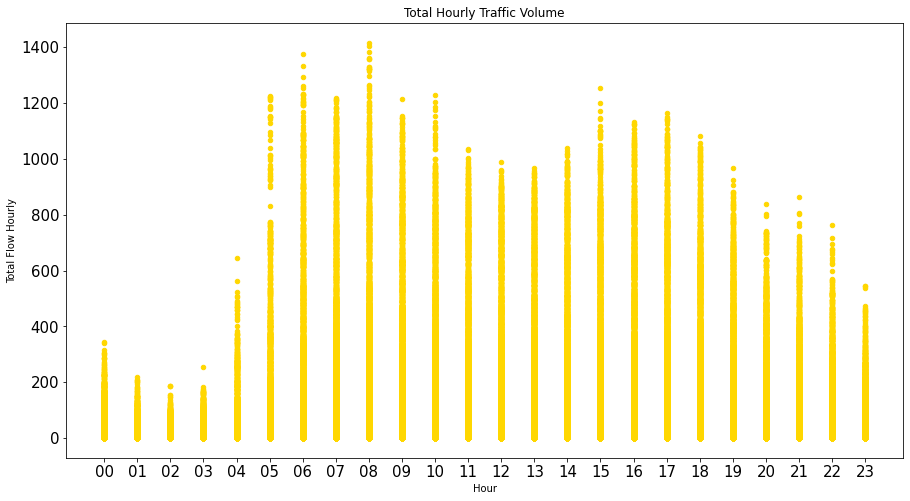

In [52]:
# Visualize the data

df_hourly.plot(kind='scatter', x='Hour', y='Total Flow Hourly', 
                     title='Total Hourly Traffic Volume', figsize=(15,8), color='gold',
                     fontsize=15);
plt.savefig(r'Hourly Traffic Volume.png', bbox_inches='tight')

We can see that on average, the traffic peaks during morning rush hour between 5 - 10 am. The volume of traffic is between 1200 - 1400 during these hours. 
There is a slight drop of traffic volume during the day although it is still around 1000 vehicles per hour. The traffic peaks again at 3 pm with traffic of 3000 vehicles per hour. There is a steady drop of traffic for the rest of the day.

Looking at this, it can be said that office commute is still the dominant flow of traffic in San Francisco area. And the rush hour for going to and back from work should be our main focus for deploying air taxis.

## Part IV - Location Modelling

### Hubs with highest traffic flow

We will now look into identifying locations with the highest volume of traffic.

In [53]:
traffic_flow = df_density[['Location Identifier', 'Total Flow Daily', 'Coordinates']].copy()

In [54]:
traffic_flow.head()

,Location Identifier,Total Flow Daily,Coordinates
0,200,383810,"(37.88613, -122.3088)"
31,201,104180,"(37.88613, -122.3088)"
62,300,187737,"(37.82503, -122.3077)"
93,301,17147,"(37.82503, -122.3077)"
124,500,363149,"(37.79847, -122.2749)"


In [55]:
traffic_flow.describe()

,Location Identifier,Total Flow Daily
count,102.000000,102.000000
mean,11980.901961,140076.186275
std,7613.244095,108624.134456
min,200.000000,13993.000000
25%,4375.750000,54663.500000
50%,13000.500000,109157.500000
75%,18275.250000,187411.500000
max,24901.000000,447536.000000


The highest traffic flow is 447,536 and the lowest is 13,993. We will only focus on traffic flow over 100,000, which still account for over 50% of the Fastrak locations. Doing this, we can gurantee enough traffic flow or demand for our airtaxi services.

In [56]:
# Create a new dataframe with over 100,000 daily traffic

traffic_flow_high = traffic_flow[traffic_flow['Total Flow Daily'] > 100000].copy()

In [57]:
traffic_flow_high.sort_values(by='Total Flow Daily', ascending=False, inplace=True)

In [58]:
traffic_flow_high.head(10)

,Location Identifier,Total Flow Daily,Coordinates
1085,5201,447536,"(37.7384, -122.4084)"
620,3501,434472,"(37.82643, -122.30126000000001)"
4061,20501,385691,"(37.777, -122.40377)"
0,200,383810,"(37.88613, -122.3088)"
124,500,363149,"(37.79847, -122.2749)"
4185,21201,362496,"(37.94784, -122.51331)"
4216,21300,344755,"(37.89692, -122.08053000000001)"
217,701,341736,"(37.82315, -122.2627)"
527,3101,340853,"(37.92863, -122.32352)"
589,3401,337869,"(37.84243, -122.2977)"


In [59]:
len(traffic_flow_high)

56

We have 56 potential locations. This still seems to be quite high for such a small area. Let's focus at the top 20 of the highest traffic locations as a starting point.

In [60]:
top_20 = list(traffic_flow_high.Coordinates.iloc[:20])

In [61]:
top_20

[(37.7384, -122.4084),
 (37.82643, -122.30126000000001),
 (37.777, -122.40377),
 (37.88613, -122.3088),
 (37.79847, -122.2749),
 (37.94784, -122.51331),
 (37.89692, -122.08053000000001),
 (37.82315, -122.2627),
 (37.92863, -122.32352),
 (37.84243, -122.2977),
 (37.56095, -122.3038),
 (37.69951, -121.92788),
 (37.56095, -122.3038),
 (37.555859999999996, -122.2858),
 (38.11394, -122.23013999999999),
 (37.63284, -122.1093),
 (38.070040000000006, -122.5387),
 (38.048140000000004, -122.2338),
 (37.94502, -122.4869),
 (37.84243, -122.2977)]

In [62]:
# Add a new layer for the top 20 locations in the previously built map

fig2.add_layer(gmaps.symbol_layer(top_20, hover_text='Airtaxi Hub', 
                                  fill_color='red',
                                  stroke_color='red',
                                  scale=4))
fig2

Figure(layout=FigureLayout(height='420px'))

The potential 20 air taxi hubs makes sense according to the traffic data we have from Fastrak data. There still are multiple locations servicing the same area. Let's cluster these together to identify key spots among the 20.

### K-Means Cluster

In [63]:
# Instantiate the model

from sklearn.cluster import KMeans
k_means = KMeans()

In [64]:
# Fit the model
k_means.fit(top_20)

KMeans()

In [65]:
# Predict the model
clusters = k_means.predict(top_20)

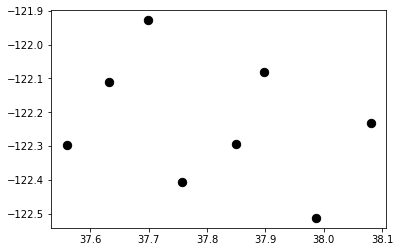

In [66]:
# Visualize the clusters
centers = k_means.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=70);

In [67]:
k_means.labels_

array([7, 0, 7, 0, 0, 3, 6, 0, 0, 0, 1, 2, 1, 1, 4, 5, 3, 4, 3, 0])

The K-means algorithm has created 8 clusters for our 20 potential locations. Let's put this back into our dataframen and plot to visualize the results.

In [68]:
# Create a new dataframe for the top 20 locations with daily volume and coordinates

top_20_df = traffic_flow_high.head(20).copy()

In [69]:
top_20_df

,Location Identifier,Total Flow Daily,Coordinates
1085,5201,447536,"(37.7384, -122.4084)"
620,3501,434472,"(37.82643, -122.30126000000001)"
4061,20501,385691,"(37.777, -122.40377)"
0,200,383810,"(37.88613, -122.3088)"
124,500,363149,"(37.79847, -122.2749)"
4185,21201,362496,"(37.94784, -122.51331)"
4216,21300,344755,"(37.89692, -122.08053000000001)"
217,701,341736,"(37.82315, -122.2627)"
527,3101,340853,"(37.92863, -122.32352)"
589,3401,337869,"(37.84243, -122.2977)"


In [70]:
# Tag the cluster label to each location

top_20_df['Hubs'] = k_means.labels_

In [71]:
top_20_df

,Location Identifier,Total Flow Daily,Coordinates,Hubs
1085,5201,447536,"(37.7384, -122.4084)",7
620,3501,434472,"(37.82643, -122.30126000000001)",0
4061,20501,385691,"(37.777, -122.40377)",7
0,200,383810,"(37.88613, -122.3088)",0
124,500,363149,"(37.79847, -122.2749)",0
4185,21201,362496,"(37.94784, -122.51331)",3
4216,21300,344755,"(37.89692, -122.08053000000001)",6
217,701,341736,"(37.82315, -122.2627)",0
527,3101,340853,"(37.92863, -122.32352)",0
589,3401,337869,"(37.84243, -122.2977)",0


In [72]:
# Rename the labels
top_20_df['Hubs'] = top_20_df['Hubs'].map({0:'Hub_1', 1:'Hub_2', 2:'Hub_3', 3:'Hub_4', 4:'Hub_5',
                                            5:'Hub_6', 6:'Hub_7', 7:'Hub_8'})
                                           

In [73]:
top_20_df

,Location Identifier,Total Flow Daily,Coordinates,Hubs
1085,5201,447536,"(37.7384, -122.4084)",Hub_8
620,3501,434472,"(37.82643, -122.30126000000001)",Hub_1
4061,20501,385691,"(37.777, -122.40377)",Hub_8
0,200,383810,"(37.88613, -122.3088)",Hub_1
124,500,363149,"(37.79847, -122.2749)",Hub_1
4185,21201,362496,"(37.94784, -122.51331)",Hub_4
4216,21300,344755,"(37.89692, -122.08053000000001)",Hub_7
217,701,341736,"(37.82315, -122.2627)",Hub_1
527,3101,340853,"(37.92863, -122.32352)",Hub_1
589,3401,337869,"(37.84243, -122.2977)",Hub_1


In [74]:
# Create list of coordinates for each hub

hub_1 = list(top_20_df[top_20_df['Hubs'] == 'Hub_1'].Coordinates)
hub_2 = list(top_20_df[top_20_df['Hubs'] == 'Hub_2'].Coordinates)
hub_3 = list(top_20_df[top_20_df['Hubs'] == 'Hub_3'].Coordinates)
hub_4 = list(top_20_df[top_20_df['Hubs'] == 'Hub_4'].Coordinates)
hub_5 = list(top_20_df[top_20_df['Hubs'] == 'Hub_5'].Coordinates)
hub_6 = list(top_20_df[top_20_df['Hubs'] == 'Hub_6'].Coordinates)
hub_7 = list(top_20_df[top_20_df['Hubs'] == 'Hub_7'].Coordinates)
hub_8 = list(top_20_df[top_20_df['Hubs'] == 'Hub_8'].Coordinates)

In [75]:
# Create layers for each hub

hub_1_layer = gmaps.symbol_layer(hub_1, hover_text='Hub_1', fill_color='red', stroke_color='red', scale=4)
hub_2_layer = gmaps.symbol_layer(hub_2, hover_text='Hub_2', fill_color='yellow', stroke_color='yellow', scale=4)
hub_3_layer = gmaps.symbol_layer(hub_3, hover_text='Hub_3', fill_color='white', stroke_color='white', scale=4)
hub_4_layer = gmaps.symbol_layer(hub_4, hover_text='Hub_4', fill_color='red', stroke_color='red', scale=4)
hub_5_layer = gmaps.symbol_layer(hub_5, hover_text='Hub_5', fill_color='yellow', stroke_color='yellow', scale=4)
hub_6_layer = gmaps.symbol_layer(hub_6, hover_text='Hub_6', fill_color='white', stroke_color='white', scale=4)
hub_7_layer = gmaps.symbol_layer(hub_7, hover_text='Hub_7', fill_color='white', stroke_color='white', scale=4)
hub_8_layer = gmaps.symbol_layer(hub_8, hover_text='Hub_8', fill_color='white', stroke_color='white', scale=4)

In [76]:
# Create a base map

fig4 = gmaps.figure(center=(37.9, -122.2), zoom_level=8)

# Add traffic density layer
fig4.add_layer(gmaps.symbol_layer(df_density.Coordinates, hover_text=fastrak_names, 
                                  fill_color='blue', fill_opacity=0.7,
                                  stroke_color='green', stroke_opacity=0.3,
                                  scale=scale))

In [77]:
# Add hub layers to the density map
fig4.add_layer(hub_1_layer)
fig4.add_layer(hub_2_layer)
fig4.add_layer(hub_3_layer)
fig4.add_layer(hub_4_layer)
fig4.add_layer(hub_5_layer)
fig4.add_layer(hub_6_layer)
fig4.add_layer(hub_7_layer)
fig4.add_layer(hub_8_layer)

fig4

Figure(layout=FigureLayout(height='420px'))

### Calinski Harabaz Score

The K means algorith had created 8 clusters. We can see there are still many locations spread across with the same cluster label. Calinski Harabaz score gives us the variance ratio that allows us to identify the best value for k.

In order to figure out the best value for  𝑘 , we'll create a different version of the clustering algorithm for each potential value of  𝑘 , and find the best one using an Elbow Plot.

In [78]:
# Initialize and fit different clusters to calculate the CH score

k_means_7 = KMeans(7)
k_means_7.fit(top_20)
k_means_8 = KMeans(8)
k_means_8.fit(top_20)
k_means_9 = KMeans(9)
k_means_9.fit(top_20)
k_means_10 = KMeans(10)
k_means_10.fit(top_20)
k_means_11 = KMeans(11)
k_means_11.fit(top_20)
k_means_12 = KMeans(12)
k_means_12.fit(top_20)
k_means_13 = KMeans(13)
k_means_13.fit(top_20)
k_means_14 = KMeans(14)
k_means_14.fit(top_20)
k_means_15 = KMeans(15)
k_means_15.fit(top_20)
k_means_16 = KMeans(16)
k_means_16.fit(top_20)
k_means_17 = KMeans(17)
k_means_17.fit(top_20)
k_means_18 = KMeans(18)
k_means_18.fit(top_20)


k_list = [k_means_7, k_means_8, k_means_9, k_means_10, k_means_11, k_means_12,
         k_means_13, k_means_14, k_means_15, k_means_16, k_means_17, k_means_18]

In [79]:
# Loop through each model and save the CH score in an empty list

CH_score = []

for model in k_list:
    label = model.labels_
    CH_score.append(calinski_harabasz_score(top_20, label))

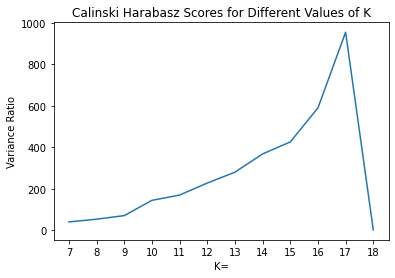

In [80]:
# Visualize the scores in an elbow plot

plt.plot([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], CH_score)
plt.xticks([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

According to the Calinski Harabasz score, 17 clusters is the optimal point after which we see diminishing returns. As much as it makes sense all 17 clusters can be well separated, we need a more economical design.

We can take a look at another metric known as Within Cluster Sum of Squares (WCSS) to confirm the optimal point.

In [81]:
# Loop through each model and save the wcss score in and empty list
wcss_score = []

for model in k_list:
    label = model.labels_
    wcss_score.append(model.inertia_)

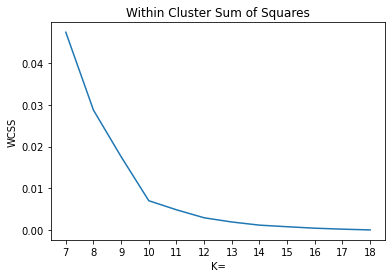

In [82]:
# Visualize the scores in an elbow plot
plt.plot([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], wcss_score)
plt.xticks([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

Although the variance ration in CH score shows 17 to be the most optimal point, we will choose 10 from the WCSS score as it is the elbow of the graph and the optimizaiton is only getting better marginally for values higher than 10.

Let's run the K-means algorithm with 10 clusters.

### Optimal K-Means cluster (k=10)

In [83]:
# Instantiate the model with 10 clusters

from sklearn.cluster import KMeans
k_means = KMeans(10)

In [84]:
# Fit the model

k_means.fit(top_20)

KMeans(n_clusters=10)

In [85]:
# Predict the model

clusters = k_means.predict(top_20)

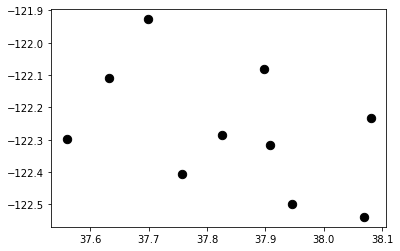

In [86]:
# Visualize the clusters

centers = k_means.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=70);

In [87]:
k_means.labels_

array([1, 2, 1, 9, 2, 8, 7, 2, 9, 2, 3, 5, 3, 3, 0, 6, 4, 0, 8, 2])

In [88]:
# Tag the cluster label to each location

top_20_df['Optimal Hubs'] = k_means.labels_

In [89]:
# Rename the labels
top_20_df['Optimal Hubs'] = top_20_df['Optimal Hubs'].map({0:'Hub_1', 1:'Hub_2', 2:'Hub_3', 3:'Hub_4', 4:'Hub_5',
                                            5:'Hub_6', 6:'Hub_7', 7:'Hub_8', 8:'Hub_9', 9:'Hub_10'})

In [90]:
top_20_df

,Location Identifier,Total Flow Daily,Coordinates,Hubs,Optimal Hubs
1085,5201,447536,"(37.7384, -122.4084)",Hub_8,Hub_2
620,3501,434472,"(37.82643, -122.30126000000001)",Hub_1,Hub_3
4061,20501,385691,"(37.777, -122.40377)",Hub_8,Hub_2
0,200,383810,"(37.88613, -122.3088)",Hub_1,Hub_10
124,500,363149,"(37.79847, -122.2749)",Hub_1,Hub_3
4185,21201,362496,"(37.94784, -122.51331)",Hub_4,Hub_9
4216,21300,344755,"(37.89692, -122.08053000000001)",Hub_7,Hub_8
217,701,341736,"(37.82315, -122.2627)",Hub_1,Hub_3
527,3101,340853,"(37.92863, -122.32352)",Hub_1,Hub_10
589,3401,337869,"(37.84243, -122.2977)",Hub_1,Hub_3


In [91]:
# Create list of coordinates for each hub
hub_1_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_1'].Coordinates)
hub_2_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_2'].Coordinates)
hub_3_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_3'].Coordinates)
hub_4_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_4'].Coordinates)
hub_5_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_5'].Coordinates)
hub_6_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_6'].Coordinates)
hub_7_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_7'].Coordinates)
hub_8_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_8'].Coordinates)
hub_9_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_9'].Coordinates)
hub_10_opt = list(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_10'].Coordinates)

In [92]:
# Create layers for each hub
hub_1_layer_opt = gmaps.symbol_layer(hub_1_opt, hover_text='Hub_1', fill_color='red', stroke_color='red', scale=4)
hub_2_layer_opt = gmaps.symbol_layer(hub_2_opt, hover_text='Hub_2', fill_color='yellow', stroke_color='yellow', scale=4)
hub_3_layer_opt = gmaps.symbol_layer(hub_3_opt, hover_text='Hub_3', fill_color='white', stroke_color='white', scale=4)
hub_4_layer_opt = gmaps.symbol_layer(hub_4_opt, hover_text='Hub_4', fill_color='red', stroke_color='red', scale=4)
hub_5_layer_opt = gmaps.symbol_layer(hub_5_opt, hover_text='Hub_5', fill_color='yellow', stroke_color='yellow', scale=4)
hub_6_layer_opt = gmaps.symbol_layer(hub_6_opt, hover_text='Hub_6', fill_color='white', stroke_color='white', scale=4)
hub_7_layer_opt = gmaps.symbol_layer(hub_7_opt, hover_text='Hub_7', fill_color='white', stroke_color='white', scale=4)
hub_8_layer_opt = gmaps.symbol_layer(hub_8_opt, hover_text='Hub_8', fill_color='white', stroke_color='white', scale=4)
hub_9_layer_opt = gmaps.symbol_layer(hub_9_opt, hover_text='Hub_9', fill_color='white', stroke_color='white', scale=4)
hub_10_layer_opt = gmaps.symbol_layer(hub_10_opt, hover_text='Hub_10', fill_color='red', stroke_color='red', scale=4)

In [93]:
# Create base map
fig5 = gmaps.figure(center=(37.9, -122.2), zoom_level=8)

# Add traffic density layer
fig5.add_layer(gmaps.symbol_layer(df_density.Coordinates, hover_text=fastrak_names, 
                                  fill_color='blue', fill_opacity=0.7,
                                  stroke_color='green', stroke_opacity=0.3,
                                  scale=scale))

In [94]:
# Add hub layers to the density map
fig5.add_layer(hub_1_layer_opt)
fig5.add_layer(hub_2_layer_opt)
fig5.add_layer(hub_3_layer_opt)
fig5.add_layer(hub_4_layer_opt)
fig5.add_layer(hub_5_layer_opt)
fig5.add_layer(hub_6_layer_opt)
fig5.add_layer(hub_7_layer_opt)
fig5.add_layer(hub_8_layer_opt)
fig5.add_layer(hub_9_layer_opt)
fig5.add_layer(hub_10_layer_opt)

fig5

Figure(layout=FigureLayout(height='420px'))

The 10 clusters seems to have fit optimally across all 20 coordinates. Visually it also makes sense to have these 10 clusters.

Let's look at the distance between each of these cluster to calculate time saves by using the air taxi service as compared to driving.

### Average co-ordinates

Since some of these clusters consists of more than one location, we will average out the coordinates to get a singular location.

In [95]:
top_20_df.head()

,Location Identifier,Total Flow Daily,Coordinates,Hubs,Optimal Hubs
1085,5201,447536,"(37.7384, -122.4084)",Hub_8,Hub_2
620,3501,434472,"(37.82643, -122.30126000000001)",Hub_1,Hub_3
4061,20501,385691,"(37.777, -122.40377)",Hub_8,Hub_2
0,200,383810,"(37.88613, -122.3088)",Hub_1,Hub_10
124,500,363149,"(37.79847, -122.2749)",Hub_1,Hub_3


In [96]:
# Create a list consisting ff all hub coordinates

hub_list = [hub_1_opt, hub_2_opt, hub_3_opt, hub_4_opt, hub_5_opt, hub_6_opt, hub_7_opt, hub_8_opt, 
            hub_9_opt, hub_10_opt]

In [97]:
# Create a function to calculate the average of the coordinates for each hub

def average(geo_list):
    lat = []
    long = []
    
    # Grab the latitude and longitudes in each cluster
    lat = [x[0] for x in geo_list]
    long = [x[1] for x in geo_list]
    
    # Calculate avearge of each lat and long
    lat_avg = sum(lat)/len(lat)
    long_avg = sum(long)/len(long)
    
    return(lat_avg, long_avg)

In [98]:
# Run the function for each hub and save it in a list

average_geos = pd.DataFrame((zip(map(average, hub_list))))

In [99]:
average_geos

,0
0,"(38.08104, -122.23196999999999)"
1,"(37.7577, -122.40608499999999)"
2,"(37.826582, -122.286852)"
3,"(37.55925333333333, -122.2978)"
4,"(38.070040000000006, -122.5387)"
5,"(37.69951, -121.92788)"
6,"(37.63284, -122.1093)"
7,"(37.89692, -122.08053000000001)"
8,"(37.94643, -122.500105)"
9,"(37.90738, -122.31616)"


In [100]:
# Rename the column

average_geos.rename(columns={0:'Coordinates'}, inplace=True)

In [101]:
# Add a new column with hub titles

average_geos['Optimal Hubs'] = ['Hub_1', 'Hub_2', 'Hub_3', 'Hub_4', 'Hub_5', 'Hub_6',
                               'Hub_7', 'Hub_8', 'Hub_9', 'Hub_10']

In [102]:
average_geos

,Coordinates,Optimal Hubs
0,"(38.08104, -122.23196999999999)",Hub_1
1,"(37.7577, -122.40608499999999)",Hub_2
2,"(37.826582, -122.286852)",Hub_3
3,"(37.55925333333333, -122.2978)",Hub_4
4,"(38.070040000000006, -122.5387)",Hub_5
5,"(37.69951, -121.92788)",Hub_6
6,"(37.63284, -122.1093)",Hub_7
7,"(37.89692, -122.08053000000001)",Hub_8
8,"(37.94643, -122.500105)",Hub_9
9,"(37.90738, -122.31616)",Hub_10


In [103]:
# Create the list for hub names

hub_names_final = list(average_geos['Optimal Hubs'])

In [160]:
# Let's plot this in the gmap
# Create a base map
fig6 = gmaps.figure(center=(37.9, -122.2), zoom_level=8)

In [161]:
# Add the final hub layer
fig6.add_layer(gmaps.symbol_layer(average_geos.Coordinates, hover_text=hub_names_final, 
                                  fill_color='black', fill_opacity=0.8,
                                  stroke_color='black', stroke_opacity=0.3,
                                  scale=8))
fig6

Figure(layout=FigureLayout(height='420px'))

We can now clearly see out final hub locations.

## Part V - Route Identification

### Combinations

To identify all possible movements across each hub, we'll have to calculate the different combinations between all of our hubs.

In [106]:
comb = pd.DataFrame(zip((combinations(['Hub_1', 'Hub_2', 'Hub_3', 'Hub_4', 'Hub_5', 'Hub_6', 
                          'Hub_7', 'Hub_8', 'Hub_9', 'Hub_10'], 2))))

In [107]:
len(comb)

45

We can see that there are 45 different possible routes among each of these hubs.

In [108]:
comb.rename(columns={0:'Potential Routes'}, inplace=True)

In [109]:
comb.head()

,Potential Routes
0,"(Hub_1, Hub_2)"
1,"(Hub_1, Hub_3)"
2,"(Hub_1, Hub_4)"
3,"(Hub_1, Hub_5)"
4,"(Hub_1, Hub_6)"


In [110]:
# Let's create a dictionary to save the coordinates for each hub so that we can access it while 
# calculcating the distance

average_geos_dict = {}
for i in range(len(average_geos)):
    average_geos_dict["Hub_{}".format(i+1)] = average_geos.Coordinates[i]

In [111]:
average_geos_dict

{'Hub_1': (38.08104, -122.23196999999999),
 'Hub_2': (37.7577, -122.40608499999999),
 'Hub_3': (37.826582, -122.286852),
 'Hub_4': (37.55925333333333, -122.2978),
 'Hub_5': (38.070040000000006, -122.5387),
 'Hub_6': (37.69951, -121.92788),
 'Hub_7': (37.63284, -122.1093),
 'Hub_8': (37.89692, -122.08053000000001),
 'Hub_9': (37.94643, -122.500105),
 'Hub_10': (37.90738, -122.31616)}

### Distance Matrix

Let's calcuate the distance and time taken to travel across each of these routes.

In [112]:
comb.head()

,Potential Routes
0,"(Hub_1, Hub_2)"
1,"(Hub_1, Hub_3)"
2,"(Hub_1, Hub_4)"
3,"(Hub_1, Hub_5)"
4,"(Hub_1, Hub_6)"


In [113]:
# Calculate distance and time across each routes and save it in a list

distance_list = []
time_list = []
    
for i in range(len(comb)):
    
    # Use Gmaps to pull the distance and time
    result = Gmaps.distance_matrix(average_geos_dict[comb.loc[i][0][0]], 
                                       average_geos_dict[comb.loc[i][0][1]], 
                                       mode='driving')
    
    # Convert distance into miles
    distance_list.append(round(result['rows'][0]['elements'][0]['distance']['value']*0.000621371,))
    
    # Convert time into minutes
    time_list.append(round(result['rows'][0]['elements'][0]['duration']['value']/60,))

In [114]:
# Add the two lists into comb dataframe

comb['Distance in Miles'] = distance_list
comb['Time taken in minutes'] = time_list

In [115]:
comb.head()

,Potential Routes,Distance in Miles,Time taken in minutes
0,"(Hub_1, Hub_2)",31,36
1,"(Hub_1, Hub_3)",22,23
2,"(Hub_1, Hub_4)",49,52
3,"(Hub_1, Hub_5)",27,30
4,"(Hub_1, Hub_6)",37,36


Now that we have all the distance between each hubs, we can look into our airtaxi models to implement our plan.

### Air Taxis

Currently there are four air taxi models in review. 

**1 - Lilium - Jet**
 - Range: 155 miles
 - Speed: 175 mph
 - Capacity: 6 + 1
 
**2 - Joby Aviation**
 - Range: 150 miles
 - Speed: 250 mph
 - Capacity: 4 + 1
 
**3 - Vertical Aerospace - VA-X4**
 - Range: 100 miles
 - Speed: 200 mph
 - Capacity: 4 + 1
 

Let's calculate the time each takes to service our hubs.

In [116]:
service_routes_df = comb.copy()

In [117]:
# Create a function to calcuate time and save it in a list

def time_taken(speed):
    
    flight_time = []
    
    for i in range(len(service_routes_df)):
        flight_time.append(round((service_routes_df['Distance in Miles'].iloc[i] / speed) * 60),)
    
    return flight_time

In [118]:
lilium_flight_time = time_taken(175)
joby_flight_time = time_taken(250)
va_x4_flight_time = time_taken(200)

Let's add this into our dataframe.

In [119]:
service_routes_df['Lilium Flight Time'] = lilium_flight_time
service_routes_df['Joby Flight Time'] = joby_flight_time
service_routes_df['VA-X4 Flight Time'] = va_x4_flight_time

In [120]:
service_routes_df.head()

,Potential Routes,Distance in Miles,Time taken in minutes,Lilium Flight Time,Joby Flight Time,VA-X4 Flight Time
0,"(Hub_1, Hub_2)",31,36,11,7,9
1,"(Hub_1, Hub_3)",22,23,8,5,7
2,"(Hub_1, Hub_4)",49,52,17,12,15
3,"(Hub_1, Hub_5)",27,30,9,6,8
4,"(Hub_1, Hub_6)",37,36,13,9,11


Let's visually compare each of these times.

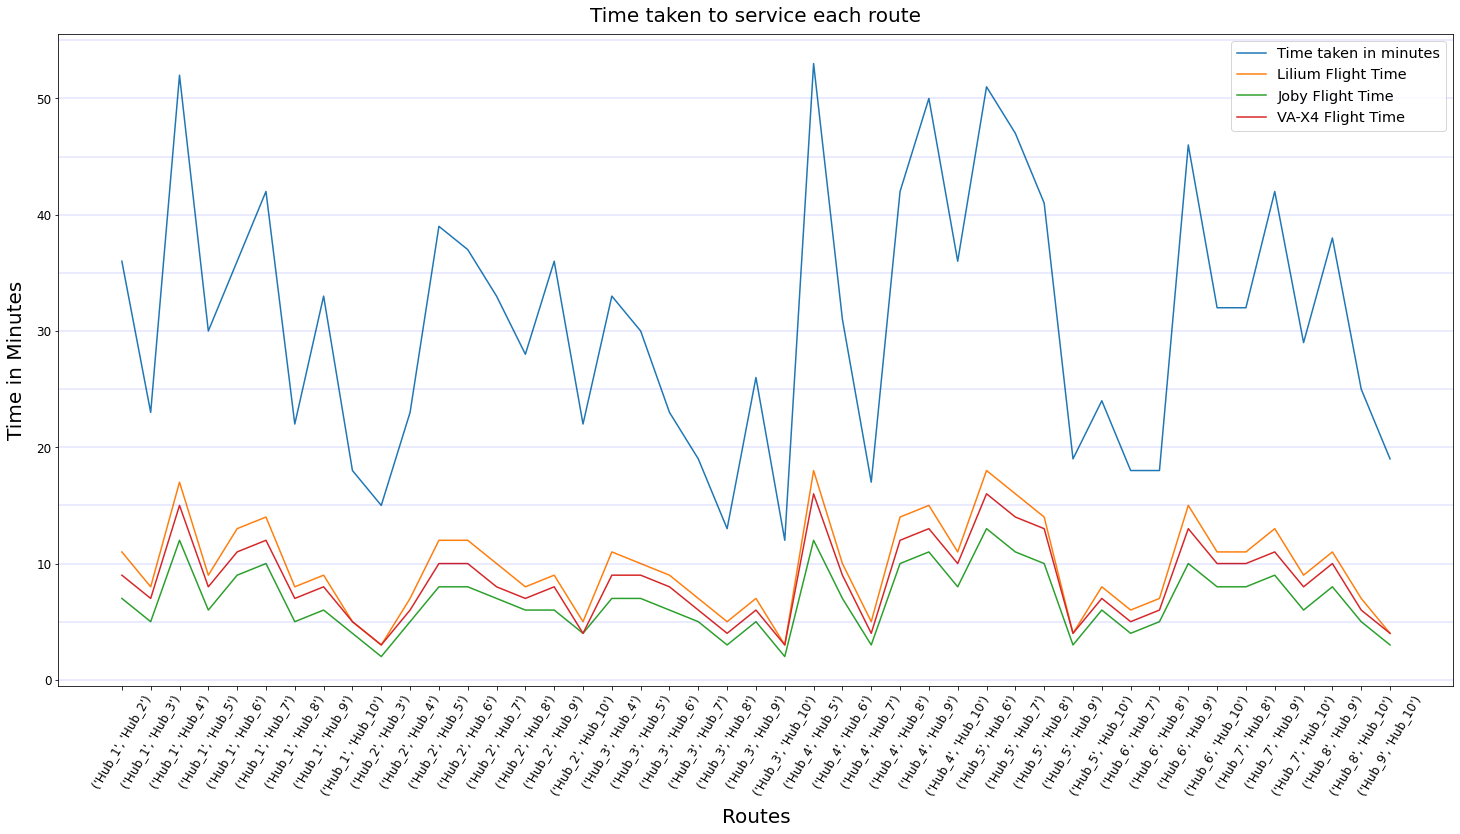

In [164]:
# Plot the data in a line graph

fig = service_routes_df.iloc[:,2:].plot(kind='line', figsize=(25,12), fontsize=12);
fig.legend(fontsize=14.5)
fig.set_ylabel('Time in Minutes', fontsize=20, labelpad=10);
fig.set_xlabel('Routes', fontsize=20, labelpad=10);
fig.set_title('Time taken to service each route', fontsize=20, pad=12);

fig.set_xticks(service_routes_df.index)
fig.set_xticklabels(service_routes_df['Potential Routes']
                   ,rotation=60)

# Use hlines to draw some distinct lines
hlines = list(range(0,60,5))
for h in hlines:
    fig.axhline(h, color='blue', ls='-', alpha=0.1);
    pass

plt.savefig(r'time_comparision.png', bbox_inches='tight')

We can clearly see the time taken to travel these routes are more than halved by the use of Air taxis.

For the initial phase we will only service routes that take more than 8 minutes to fly. Let's sort the dataframe as such.

In [122]:
first_round_flights = service_routes_df[(service_routes_df['Lilium Flight Time'] >= 8) &
                                        (service_routes_df['Joby Flight Time'] >= 8) &
                                        (service_routes_df['VA-X4 Flight Time'] >= 8)].copy()

In [123]:
len(first_round_flights)

17

We now have identified 17 routes that we can begin service at.

In [124]:
first_round_flights

,Potential Routes,Distance in Miles,Time taken in minutes,Lilium Flight Time,Joby Flight Time,VA-X4 Flight Time
2,"(Hub_1, Hub_4)",49,52,17,12,15
4,"(Hub_1, Hub_6)",37,36,13,9,11
5,"(Hub_1, Hub_7)",41,42,14,10,12
11,"(Hub_2, Hub_5)",35,39,12,8,10
12,"(Hub_2, Hub_6)",34,37,12,8,10
24,"(Hub_4, Hub_5)",52,53,18,12,16
27,"(Hub_4, Hub_8)",41,42,14,10,12
28,"(Hub_4, Hub_9)",44,50,15,11,13
29,"(Hub_4, Hub_10)",32,36,11,8,10
30,"(Hub_5, Hub_6)",53,51,18,13,16


Let's plot the routes in the map for these.

In [162]:
hub_1_path = gmaps.drawing_layer(features=[gmaps.Line(average_geos_dict[first_round_flights.iloc[0][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[0][0][1]],
                                                      stroke_color='red', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[1][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[1][0][1]],
                                                      stroke_color='red', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[2][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[2][0][1]],
                                                      stroke_color='red', stroke_weight=1, stroke_opacity=1)
                                          ])
                                                                        
hub_2_path = gmaps.drawing_layer(features=[gmaps.Line(average_geos_dict[first_round_flights.iloc[3][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[3][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[4][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[4][0][1]],
                                                      stroke_color='black', stroke_weight=1, stroke_opacity=1)
                                          ])

hub_4_path = gmaps.drawing_layer(features=[gmaps.Line(average_geos_dict[first_round_flights.iloc[5][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[5][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[6][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[6][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[7][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[7][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[8][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[8][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1)
                                          ])


hub_5_path = gmaps.drawing_layer(features=[gmaps.Line(average_geos_dict[first_round_flights.iloc[9][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[9][0][1]],
                                                      stroke_color='red', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[10][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[10][0][1]],
                                                      stroke_color='red', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[11][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[11][0][1]],
                                                      stroke_color='red', stroke_weight=1, stroke_opacity=1)
                                          ])

hub_6_path = gmaps.drawing_layer(features=[gmaps.Line(average_geos_dict[first_round_flights.iloc[12][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[12][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[13][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[13][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1),
                                          ])

hub_7_path = gmaps.drawing_layer(features=[gmaps.Line(average_geos_dict[first_round_flights.iloc[14][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[14][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1),
                                           gmaps.Line(average_geos_dict[first_round_flights.iloc[15][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[15][0][1]],
                                                      stroke_color='blue', stroke_weight=1, stroke_opacity=1)
                                          ])


hub_8_path = gmaps.drawing_layer(features=[gmaps.Line(average_geos_dict[first_round_flights.iloc[16][0][0]], 
                                                      average_geos_dict[first_round_flights.iloc[16][0][1]],
                                                      stroke_color='green', stroke_weight=1, stroke_opacity=1)
                                          ]) 

In [163]:
fig6.add_layer(hub_1_path)
fig6.add_layer(hub_2_path)
fig6.add_layer(hub_4_path)
fig6.add_layer(hub_5_path)
fig6.add_layer(hub_6_path)
fig6.add_layer(hub_7_path)
fig6.add_layer(hub_8_path)
fig6

Figure(layout=FigureLayout(height='420px'))

The routes are colored to show taxis moving in different directions:
    
    - Red: Southbound
    - Blue: Northbound
    - Green: Westbound
    - Black: Eastbound

### Identify time saved at each route

In [127]:
time_df = first_round_flights.copy()

In [128]:
# Calculate average time saved on each route


# Create two empty lists
average_time_taken = []
average_time_saved = []

# Loop through the dataframe to calculate average time among the three aircrafts
for i in range(len(time_df)):
    
    # Calculate average time 
    average_time = round(((time_df['Lilium Flight Time'].iloc[i] 
                   + time_df['Joby Flight Time'].iloc[i] 
                   + time_df['VA-X4 Flight Time'].iloc[i]) / 3),)
    average_time_taken.append(average_time)
    
    # Calculate time saved
    time_saved = time_df['Time taken in minutes'].iloc[i] - average_time
    average_time_saved.append(time_saved) 

In [129]:
# Add the two new lists into the dataframe

time_df['Average Time Taken in Airtaxi'] = average_time_taken
time_df['Average Time Saved in Airtaxi'] = average_time_saved

In [130]:
# Create a Factor Multiplier column to check how fast the aircrafts are

time_df['Factor Multiplier'] = round(time_df['Time taken in minutes'] / time_df['Average Time Taken in Airtaxi'],)

In [131]:
time_df.head()

,Potential Routes,Distance in Miles,Time taken in minutes,Lilium Flight Time,Joby Flight Time,VA-X4 Flight Time,Average Time Taken in Airtaxi,Average Time Saved in Airtaxi,Factor Multiplier
2,"(Hub_1, Hub_4)",49,52,17,12,15,15,37,3.0
4,"(Hub_1, Hub_6)",37,36,13,9,11,11,25,3.0
5,"(Hub_1, Hub_7)",41,42,14,10,12,12,30,4.0
11,"(Hub_2, Hub_5)",35,39,12,8,10,10,29,4.0
12,"(Hub_2, Hub_6)",34,37,12,8,10,10,27,4.0


In [132]:
time_df['Factor Multiplier'].value_counts()

4.0    10
3.0     7
Name: Factor Multiplier, dtype: int64

we can see from the 'Factor multiplier' that Airtaxis are atleast 3 to 4 times faster than conventional ways of travel.

## Part VI - Demand Estimation

### Identify demand at each location

In [133]:
# Create a new dataframe

demand_df = first_round_flights[['Potential Routes']].copy()

In [134]:
# Let's split the routes into two locations

demand_df[['Location_1', 'Location_2']] = pd.DataFrame(demand_df['Potential Routes'].tolist(), index=demand_df.index)

In [135]:
demand_df.head()

,Potential Routes,Location_1,Location_2
2,"(Hub_1, Hub_4)",Hub_1,Hub_4
4,"(Hub_1, Hub_6)",Hub_1,Hub_6
5,"(Hub_1, Hub_7)",Hub_1,Hub_7
11,"(Hub_2, Hub_5)",Hub_2,Hub_5
12,"(Hub_2, Hub_6)",Hub_2,Hub_6


We will have to pull the demand values from top_20_df dataframe.

In [136]:
top_20_df.head()

,Location Identifier,Total Flow Daily,Coordinates,Hubs,Optimal Hubs
1085,5201,447536,"(37.7384, -122.4084)",Hub_8,Hub_2
620,3501,434472,"(37.82643, -122.30126000000001)",Hub_1,Hub_3
4061,20501,385691,"(37.777, -122.40377)",Hub_8,Hub_2
0,200,383810,"(37.88613, -122.3088)",Hub_1,Hub_10
124,500,363149,"(37.79847, -122.2749)",Hub_1,Hub_3


In [137]:
# Let's create a dictionary to save the sum total of volumes observed in each hub

volume_dict = {}

for i in range(1,11):
    volume_dict['Hub_{}'.format(i)] = sum(top_20_df[top_20_df['Optimal Hubs'] == 'Hub_{}'.format(i)]
                                          ['Total Flow Daily'])

In [138]:
volume_dict

{'Hub_1': 524796,
 'Hub_2': 833227,
 'Hub_3': 1716065,
 'Hub_4': 902631,
 'Hub_5': 262566,
 'Hub_6': 322395,
 'Hub_7': 267413,
 'Hub_8': 344755,
 'Hub_9': 606062,
 'Hub_10': 724663}

Since we have aggregated multiple locations into our optimal hubs, we will take the sum total of all traffic flow observed in those locations for each hub.

We will now insert these values in demand_df dataframe.

In [139]:
demand_df.head()

,Potential Routes,Location_1,Location_2
2,"(Hub_1, Hub_4)",Hub_1,Hub_4
4,"(Hub_1, Hub_6)",Hub_1,Hub_6
5,"(Hub_1, Hub_7)",Hub_1,Hub_7
11,"(Hub_2, Hub_5)",Hub_2,Hub_5
12,"(Hub_2, Hub_6)",Hub_2,Hub_6


In [140]:
# Pull values from the newly created dictionary and insert it in a column 

demand_df['Volume_1'] = [volume_dict[x] for x in demand_df['Location_1']] 
demand_df['Volume_2'] = [volume_dict[x] for x in demand_df['Location_2']]

In [141]:
demand_df

,Potential Routes,Location_1,Location_2,Volume_1,Volume_2
2,"(Hub_1, Hub_4)",Hub_1,Hub_4,524796,902631
4,"(Hub_1, Hub_6)",Hub_1,Hub_6,524796,322395
5,"(Hub_1, Hub_7)",Hub_1,Hub_7,524796,267413
11,"(Hub_2, Hub_5)",Hub_2,Hub_5,833227,262566
12,"(Hub_2, Hub_6)",Hub_2,Hub_6,833227,322395
24,"(Hub_4, Hub_5)",Hub_4,Hub_5,902631,262566
27,"(Hub_4, Hub_8)",Hub_4,Hub_8,902631,344755
28,"(Hub_4, Hub_9)",Hub_4,Hub_9,902631,606062
29,"(Hub_4, Hub_10)",Hub_4,Hub_10,902631,724663
30,"(Hub_5, Hub_6)",Hub_5,Hub_6,262566,322395


Let's assume only 10% of the total travellers decide to take our Airtaxi.

In [142]:
# Create new columns with 10% of total volumes

demand_df['Volume_1_10%'] = round((demand_df.Volume_1/10),)
demand_df['Volume_2_10%'] = round((demand_df.Volume_2/10),)

In [143]:
demand_df

,Potential Routes,Location_1,Location_2,Volume_1,Volume_2,Volume_1_10%,Volume_2_10%
2,"(Hub_1, Hub_4)",Hub_1,Hub_4,524796,902631,52480.0,90263.0
4,"(Hub_1, Hub_6)",Hub_1,Hub_6,524796,322395,52480.0,32240.0
5,"(Hub_1, Hub_7)",Hub_1,Hub_7,524796,267413,52480.0,26741.0
11,"(Hub_2, Hub_5)",Hub_2,Hub_5,833227,262566,83323.0,26257.0
12,"(Hub_2, Hub_6)",Hub_2,Hub_6,833227,322395,83323.0,32240.0
24,"(Hub_4, Hub_5)",Hub_4,Hub_5,902631,262566,90263.0,26257.0
27,"(Hub_4, Hub_8)",Hub_4,Hub_8,902631,344755,90263.0,34476.0
28,"(Hub_4, Hub_9)",Hub_4,Hub_9,902631,606062,90263.0,60606.0
29,"(Hub_4, Hub_10)",Hub_4,Hub_10,902631,724663,90263.0,72466.0
30,"(Hub_5, Hub_6)",Hub_5,Hub_6,262566,322395,26257.0,32240.0


That is still a significant level of demand at 10%. If we operate from 6 AM - 12 AM, let's check the hourly demand for 18 hours of operation.

In [144]:
# Create new columns for volumes per hour

demand_df['Vol_1_10%_Hourly'] = round((demand_df['Volume_1_10%'] / 18),)
demand_df['Vol_2_10%_Hourly'] = round((demand_df['Volume_2_10%'] / 18),)

In [145]:
demand_df

,Potential Routes,Location_1,Location_2,Volume_1,Volume_2,Volume_1_10%,Volume_2_10%,Vol_1_10%_Hourly,Vol_2_10%_Hourly
2,"(Hub_1, Hub_4)",Hub_1,Hub_4,524796,902631,52480.0,90263.0,2916.0,5015.0
4,"(Hub_1, Hub_6)",Hub_1,Hub_6,524796,322395,52480.0,32240.0,2916.0,1791.0
5,"(Hub_1, Hub_7)",Hub_1,Hub_7,524796,267413,52480.0,26741.0,2916.0,1486.0
11,"(Hub_2, Hub_5)",Hub_2,Hub_5,833227,262566,83323.0,26257.0,4629.0,1459.0
12,"(Hub_2, Hub_6)",Hub_2,Hub_6,833227,322395,83323.0,32240.0,4629.0,1791.0
24,"(Hub_4, Hub_5)",Hub_4,Hub_5,902631,262566,90263.0,26257.0,5015.0,1459.0
27,"(Hub_4, Hub_8)",Hub_4,Hub_8,902631,344755,90263.0,34476.0,5015.0,1915.0
28,"(Hub_4, Hub_9)",Hub_4,Hub_9,902631,606062,90263.0,60606.0,5015.0,3367.0
29,"(Hub_4, Hub_10)",Hub_4,Hub_10,902631,724663,90263.0,72466.0,5015.0,4026.0
30,"(Hub_5, Hub_6)",Hub_5,Hub_6,262566,322395,26257.0,32240.0,1459.0,1791.0


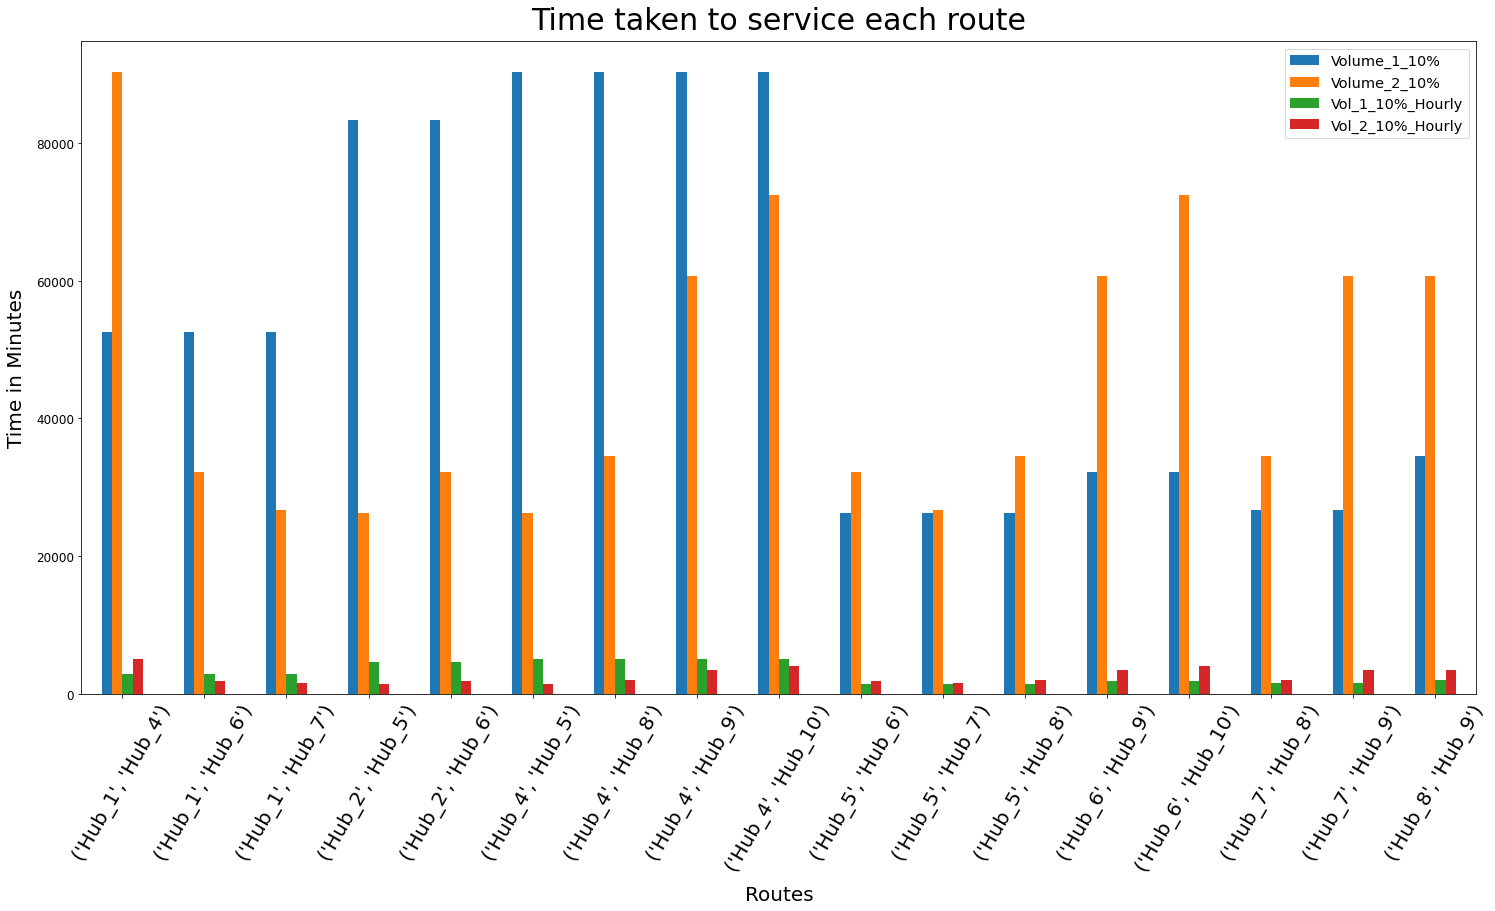

In [180]:
# Plot the data in a bar graph

fig = demand_df.iloc[:,5:].plot(kind='bar', figsize=(25,12), fontsize=12);
fig.legend(fontsize=14.5)
fig.set_ylabel('Time in Minutes', fontsize=20, labelpad=10);
fig.set_xlabel('Routes', fontsize=20, labelpad=10);
fig.set_title('Time taken to service each route', fontsize=30, pad=12);

fig.set_xticklabels(demand_df['Potential Routes'], rotation=60, fontsize=20)

plt.savefig(r'demand.png', bbox_inches='tight')

In [146]:
# Check the statistics of the results

demand_df.describe()

,Volume_1,Volume_2,Volume_1_10%,Volume_2_10%,Vol_1_10%_Hourly,Vol_2_10%_Hourly
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,539025.588235,461036.058824,53902.764706,46103.705882,2994.823529,2561.352941
std,275112.154368,204652.587415,27511.108994,20465.031730,1528.437038,1136.986529
min,262566.000000,262566.000000,26257.000000,26257.000000,1459.000000,1459.000000
25%,267413.000000,322395.000000,26741.000000,32240.000000,1486.000000,1791.000000
50%,524796.000000,344755.000000,52480.000000,34476.000000,2916.000000,1915.000000
75%,833227.000000,606062.000000,83323.000000,60606.000000,4629.000000,3367.000000
max,902631.000000,902631.000000,90263.000000,90263.000000,5015.000000,5015.000000


In conclusion:
    
- On an average there seems to be an hourly demand of above 2500 customers at all locations. This only represents 10% of the total flow of traffic daily.
- Considering most of the travel is happening during morning and evening rush hours, an operating schedule between the hours of 6 AM till 12 AM would benefit the most travellers.
- In terms of service locations, we identified a total of 10 locations that would be optimal to cover all movements across the area.
- Considering all combination of travel between these locations, and keeping only the routes that take at least 8 minutes of flight time, we arrive at 15 different routes that will benefit the most from this service.
- Each of these routes are at least 4 times faster than conventional travel.
    
By looking at just the Fastrak data, we are able to identify the most optimal locations, routes that covers the most distance and forecast an average demand of 50,000 travellers everyday. Regardless of what air taxi we choose or follow a certain pricing plan, it is pretty evident that there will be more than enough demand for this service. The travel being more than 4-5 times faster will also make this service invaluable at all price ranges. This is a great opportunity and investors should definitely take part to make this a success.